# Non-convex Nonlinear Programming

cvxpy requires convex objectives and constraints. If that's not the case, for example, if we have a black-box model, we need to use other NLP algorithms. scipy has several such solvers. We'll compare scipy.optimize.minimize with different gradient-based solvers using multi-start and scipy.optimize.differential_evolution, an evolutionary algorithm, on a hydrological model calibration problem.

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, differential_evolution

We'll use the simple hydrological model hymod on a dataset of one year from the Rivanna River at Palmyra in from HY 2011-2023. We'll use the dataretrieval package to get the streamflow data from USGS (https://github.com/DOI-USGS/dataretrieval-python) and the pyncei package to get the climate data from NOAA (https://github.com/adamancer/pyncei).

In [ ]:
!pip install dataretrieval
!pip install pyncei

In [ ]:
import dataretrieval.nwis as nwis
flow_df = nwis.get_record(sites='02034000', service='dv', start='2010-10-01', end='2023-09-30') # Rivanna River at Palmyra in cfs
flow_df.head()

,00060_Mean,00060_Mean_cd,site_no
datetime,,,
2010-10-01 00:00:00+00:00,2890.0,A,02034000
2010-10-02 00:00:00+00:00,1150.0,"A, e",02034000
2010-10-03 00:00:00+00:00,428.0,"A, e",02034000
2010-10-04 00:00:00+00:00,255.0,"A, e",02034000
2010-10-05 00:00:00+00:00,206.0,A,02034000


Before downloading the NOAA climate data, you'll need to get your own token here: https://www.ncdc.noaa.gov/cdo-web/token. Replace my token with your own.

In [ ]:
from pyncei import NCEIBot
#ncei = NCEIBot("ExampleNCEIAPIToken")
ncei = NCEIBot("klhIxphHLKDrrnjPtJGNpfEnfbERfUvZ")

In [ ]:
# loop through each year and append to data frame because you can't download more than 1 year at a time
for year in range(2010,2023):
  response = ncei.get_data(
      datasetid="GHCND",
      stationid=["GHCND:USC00441593"],# Charlottesville, VA; should really use average over basin
      datatypeid=["TOBS", "TMAX", "TMIN", "PRCP"], # degrees Celsius, mm
      startdate=str(year) + "-10-01",
      enddate=str(year+1) + "-09-30",
  )
  if year == 2010:
    climate_df = response.to_dataframe()
  else:
    climate_df = pd.concat([climate_df,response.to_dataframe()])

climate_df.head()

Reformat the data so each variable is stored in a separate dataframe with the date

In [ ]:
from datetime import datetime

def make_table(table_in, col_str):
  data_table = pd.DataFrame()
  data_table[col_str] = table_in['value'].iloc[np.where(table_in['datatype']==col_str)[0]]
  data_table['date'] = table_in['date'].iloc[np.where(table_in['datatype']==col_str)[0]]
  data_table = data_table.reset_index()
  data_table['date'] = [datetime.strftime(dt, "%Y-%m-%d") for dt in data_table['date']]
  data_table.index = data_table['date']
  data_table = data_table.drop(columns=['date','index'])
  return data_table

data_P = make_table(climate_df, "PRCP")
data_T = make_table(climate_df, "TOBS")
data_Tmax = make_table(climate_df, "TMAX")
data_Tmin = make_table(climate_df, "TMIN")

data_Q = pd.DataFrame()
data_Q['Q'] = flow_df['00060_Mean']
data_Q['date'] = [datetime.strftime(dt, "%Y-%m-%d") for dt in data_Q.index]
data_Q.index = data_Q['date']
data_Q = data_Q.drop(columns=['date'])

print(data_P.head())
print(data_T.head())
print(data_Tmax.head())
print(data_Tmin.head())
print(data_Q.head())

print(len(data_P))
print(len(data_T))
print(len(data_Tmax))
print(len(data_Tmin))
print(len(data_Q))

The datasets are different lengths, so some variables must have missing values. Join the data frames and fill the missing values via interpolation.

In [ ]:
data = data_Q.join(data_P)
data = data.join(data_Tmax)
data = data.join(data_Tmin)
data = data.join(data_T)
print(data.isna().sum())
data.interpolate('linear',axis=0,inplace=True)
print(data.isna().sum())
data.index = pd.to_datetime(data.index)

Estimate PET using Hargreaves because it only requires temperature and latitude (and therefore isn't the best approach, but we're using a simple example). Code for PET calculation is available here: https://github.com/pyet-org/pyet

In [ ]:
!pip install pyet

In [ ]:
lat = 37.8579192*np.pi/180.0 # latitude of Palmyra in radians (should really use latitude at centroid of basin)
elevation = 209.69/3.28084 # elevation of Palmyra gauge in feet converted to meters
area = 663*5280**2 # drainage area of Rivanna River at Palmyra in square miles converted to square ft

import pyet
data['PET'] = pyet.hargreaves(tmean=data['TOBS'], tmax=data['TMAX'], tmin=data['TMIN'], lat=lat)
data.head()

Convert data frames to numpy arrays to run HYMOD

In [ ]:
data_Q = np.array(data['Q'])*3600*24*1000/3.28/area # convert cfs to mm/day
data_P = np.array(data['PRCP']) # mm/day
data_PET = np.array(data['PET']) # mm/day
ndays = len(data_Q)

print(data_Q)

Function for HYMOD model  
&nbsp;  
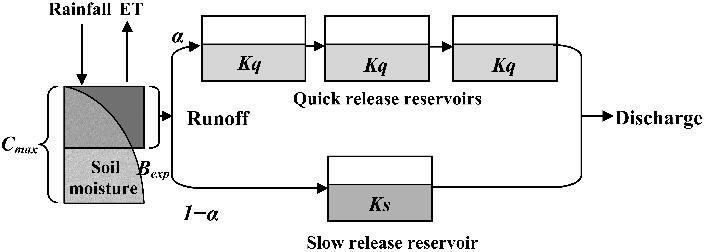

In [ ]:
def hymod(x, mode='optimize'):

    # assign parameters
    Sm_max,B,alpha,Kf,Ks = list(x)

    # initialize storage, all empty to start
    Sm,Sf1,Sf2,Sf3,Ss1 = [np.zeros(ndays) for _ in range(5)]
    Q = np.zeros(ndays)

    for t in range(1,ndays):

        # calculate all fluxes
        P = data_P[t]
        Peff = P*(1 - max(1-Sm[t-1]/Sm_max,0)**B) # PDM model Moore 1985
        Evap = min(data_PET[t]*(Sm[t-1]/Sm_max), Sm[t-1])

        Qf1 = Kf*Sf1[t-1]
        Qf2 = Kf*Sf2[t-1]
        Qf3 = Kf*Sf3[t-1]
        Qs1 = Ks*Ss1[t-1]

        # update state variables
        Sm[t] = Sm[t-1] + P - Peff - Evap
        Sf1[t] = Sf1[t-1] + alpha*Peff - Qf1
        Sf2[t] = Sf2[t-1] + Qf1 - Qf2
        Sf3[t] = Sf3[t-1] + Qf2 - Qf3
        Ss1[t] = Ss1[t-1] + (1-alpha)*Peff - Qs1

        Q[t] = Qs1 + Qf3

    if mode=='simulate':
        return Q # simulated flow
    else:
        # remove first 3 years as burn-in
        Qsim = Q[(365*3)::]
        Qobs = data_Q[(365*3)::]

        # compute log-space flows (add a small constant in case any are 0)
        logQ_sim = np.log(Qsim+0.001)
        logQ_obs = np.log(Qobs+0.001)

        #compute log-space NSE
        logNSE = 1 - np.sum((logQ_sim-logQ_obs)**2)/np.sum((logQ_obs - np.mean(logQ_obs))**2)

        return -logNSE # negate to minimize

Generate 10 initial starting points from a Latin hypercube sample.

In [ ]:
import scipy.stats as ss
sampler = ss.qmc.LatinHypercube(d=5)
sample = sampler.random(n=10)
l_bounds = np.zeros([5])
u_bounds = np.array([500,2,1,1,0.1])
x0 = ss.qmc.scale(sample, l_bounds, u_bounds)
x0

Optimize with differential evolution using the Latin hypercube sample as the initial population. See more about arguments here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html

In [ ]:
bounds = [(0, 500), (0, 2), (0, 1), (0, 1), (0, 0.1)]
DEresult = differential_evolution(hymod, bounds=bounds, init=x0, seed=1, maxiter=1000)

print("Best log-space NSE: %0.2f" % -DEresult.fun)
print("Best Sm_max value: %0.2f" % DEresult.x[0])
print("Best B value: %0.2f" % DEresult.x[1])
print("Best alpha value: %0.2f" % DEresult.x[2])
print("Best Kf value: %0.2f" % DEresult.x[3])
print("Best Ks value: %0.2f" % DEresult.x[4])

Store best parameter set and corresponding log-space RMSE

In [ ]:
DE_x_best = DEresult.x
DE_obj_best = DEresult.fun

Optimize with scipy minimize, which defaults to BFGS, L-BFGS-B, SLSQP, depending on whether or not the problem has constraints or bounds. Use multi-start, initiating each search with one of the Latin hypercube samples. See more here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html.

In [ ]:
x_trial = np.zeros([10,5])
RMSE_trial = np.zeros(10)
for i in range(10):
  BFGSresult = minimize(hymod, x0[i,:], bounds=bounds)
  x_trial[i,:] = BFGSresult.x
  RMSE_trial[i] = BFGSresult.fun

BFGS_obj_best = np.min(RMSE_trial)
BFGS_x_best = x_trial[np.argmin(RMSE_trial)]

print("Best log-space NSE: %0.2f" % -BFGS_obj_best)
print("Best Sm_max value: %0.2f" % BFGS_x_best[0])
print("Best B value: %0.2f" % BFGS_x_best[1])
print("Best alpha value: %0.2f" % BFGS_x_best[2])
print("Best Kf value: %0.2f" % BFGS_x_best[3])
print("Best Ks value: %0.2f" % BFGS_x_best[4])

Compare observations vs. simulations from best DE solution and best gradient-based (BFGS) solution

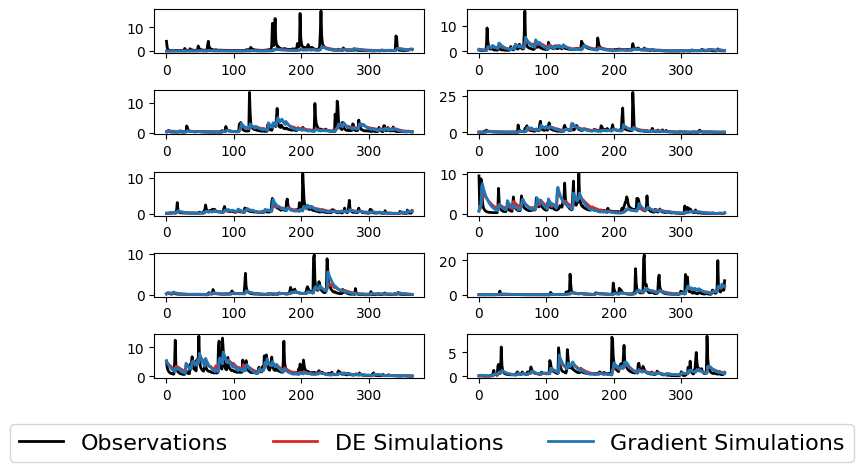

In [ ]:
import matplotlib.pyplot as plt

sim_Q_DE = hymod(DE_x_best, mode='simulate')
sim_Q_BFGS = hymod(BFGS_x_best, mode='simulate')

# make each year its own subplot
fig = plt.figure()
for i in range(10): # last 10 years
  ax = fig.add_subplot(5,2,i+1)
  ax.plot(data_Q[(i*365):((i+1)*365)],c="black",linewidth=2,label="Observations")
  ax.plot(sim_Q_DE[(i*365):((i+1)*365)],c="tab:red",linewidth=2,label="DE Simulations")
  ax.plot(sim_Q_BFGS[(i*365):((i+1)*365)],c="tab:blue",linewidth=2,label="Gradient Simulations")

fig.tight_layout()
handles, labels = ax.get_legend_handles_labels()
fig.subplots_adjust(bottom=0.2)
fig.legend(handles, labels, fontsize=16,loc='lower center',ncol=3)
fig.show()


Now let's try a multimodal test problem: the Ackley function. This problem can be of any dimension d. We'll plot it in 2 dimensions, but solve for the 5-dimensional version.

In [ ]:
a=20
b=1/5
c=2*np.pi
def Ackley(x):
  n = len(x)
  T1 = -a*np.exp(-b*np.sqrt((1/n)*sum(x**2)))
  T2 = 0
  for i in range(n):
    T2 += np.cos(c*x[i])

  T2 = -np.exp((1/n)*T2)
  return T1 + T2 + a + np.exp(1)

# Comput Ackley function over 2D grid
X = np.arange(-5, 5, 0.01)
Y = np.arange(-5, 5, 0.01)
X, Y = np.meshgrid(X,Y)
Z = np.empty(np.shape(X))
for i in range(np.shape(Z)[0]):
  for j in range(np.shape(Z)[1]):
    Z[i,j] = Ackley(np.array([X[i,j],Y[i,j]]))

# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
l_bounds = -np.ones([5])*32.768
u_bounds = np.ones([5])*32.768
bounds = [[-32.768,32.768]]*5
x0 = ss.qmc.scale(sample, l_bounds, u_bounds)

DEresult = differential_evolution(Ackley, bounds=bounds, init=x0, seed=1, maxiter=1000)
x_trial = np.zeros([10,5])
RMSE_trial = np.zeros(10)
for i in range(10):
  BFGSresult = minimize(Ackley, x0[i,:], bounds=bounds)
  x_trial[i,:] = BFGSresult.x
  RMSE_trial[i] = BFGSresult.fun

BFGS_obj_best = np.min(RMSE_trial)
BFGS_x_best = x_trial[np.argmin(RMSE_trial)]

print('Best DE result: %0.5f' % DEresult.fun)
print('Best BFGS result: %0.5f' % BFGS_obj_best)